<a href="https://colab.research.google.com/github/Andrew-Ka/CNN-Muffins-Vs-Chihuahuas/blob/main/Muffin_vs_Chihuahua.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using a Convolutional Neural Network (CNN) to Determing Differences Between Images of Muffins vs Chichuahua

### Andrew Kalathra
### Multimedia Processing
### CPSC 4330
### Dr. Jane Lui
### 11/20/2024

Inspire by this meme:   
<image src="https://i.postimg.cc/2SXNWP7f/muffin-meme2.jpg">


## Importing TensorFlow

In [1]:
#importing tensorflow
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
import pathlib
import os
import random
import numpy as np
#by the end of this, I will have every single importable library

#avoid OOM error by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

## Getting the Data Sets
This generally follows the format given by <a href = "https://youtu.be/jztwpsIzEGc">this video</a>.  
I was able to use the Kaggle <a href="https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification/data"> dataset </a> directly in CoLab. This dataset was too large for my use, so I made <a href = "https://www.kaggle.com/datasets/vancomycinseagull/muffins-vs-chihuahua/data">my own subset </a> off of the prior dataset.


In [2]:
#downloading the dataset
# "!" means shell cmd
! kaggle datasets download vancomycinseagull/muffins-vs-chihuahua
#unzip the file and put it in its own dir
with zipfile.ZipFile("muffins-vs-chihuahua.zip", 'r') as zip_ref:
  zip_ref.extractall("/content/MufVSChu")

#now to use the data, we need to load it
trainDS = keras.utils.image_dataset_from_directory(directory='/content/MufVSChu/new archive/new train', labels='inferred')
testDS = keras.utils.image_dataset_from_directory(directory='/content/MufVSChu/new archive/new test', labels='inferred')

Dataset URL: https://www.kaggle.com/datasets/vancomycinseagull/muffins-vs-chihuahua
License(s): CC0-1.0
 92% 136M/148M [00:01<00:00, 135MB/s]
100% 148M/148M [00:01<00:00, 123MB/s]
Found 1529 files belonging to 2 classes.
Found 211 files belonging to 2 classes.


## Verify the Data
I will verify the data by plotting the first few images from the training set and displaying the label for each image. Each batch has 32 images, but for simplicity, we will just display 4 of the batch.

In [3]:
#stick the data into a numpy array
trainData = tf.keras.utils.image_dataset_from_directory('/content/MufVSChu/new archive/new train')


#preprocessing, to scale down from 0-255 to 0-1
trainData = trainData.map(lambda x, y: (x/255, y))

Found 1529 files belonging to 2 classes.


Instead of loading all the data into an array (which takes waaaaay to long), we can use a data generator.


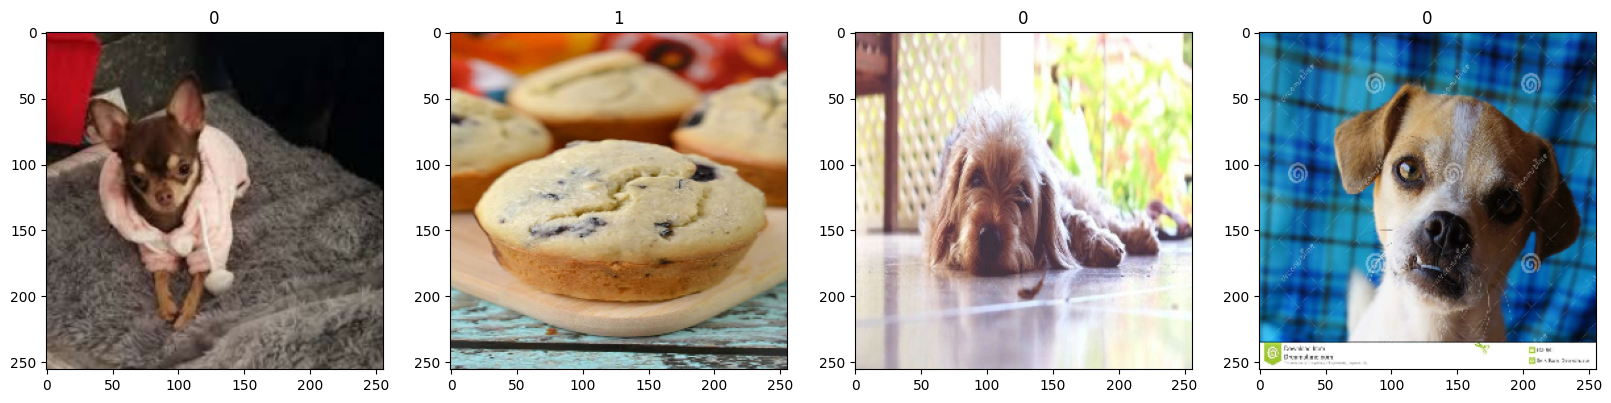

In [4]:
#making a numpy iterator
trainData_iterator = trainData.as_numpy_iterator()

#making batches
trainBatch = trainData_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(trainBatch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(trainBatch[1][idx])

In [5]:
#also have to do this for the testing data
#stick the data into a numpy array
testData = tf.keras.utils.image_dataset_from_directory('/content/MufVSChu/new archive/new test')

#preprocessing, to scale down from 0-255 to 0-1
testData = testData.map(lambda x, y: (x/255, y))

Found 211 files belonging to 2 classes.


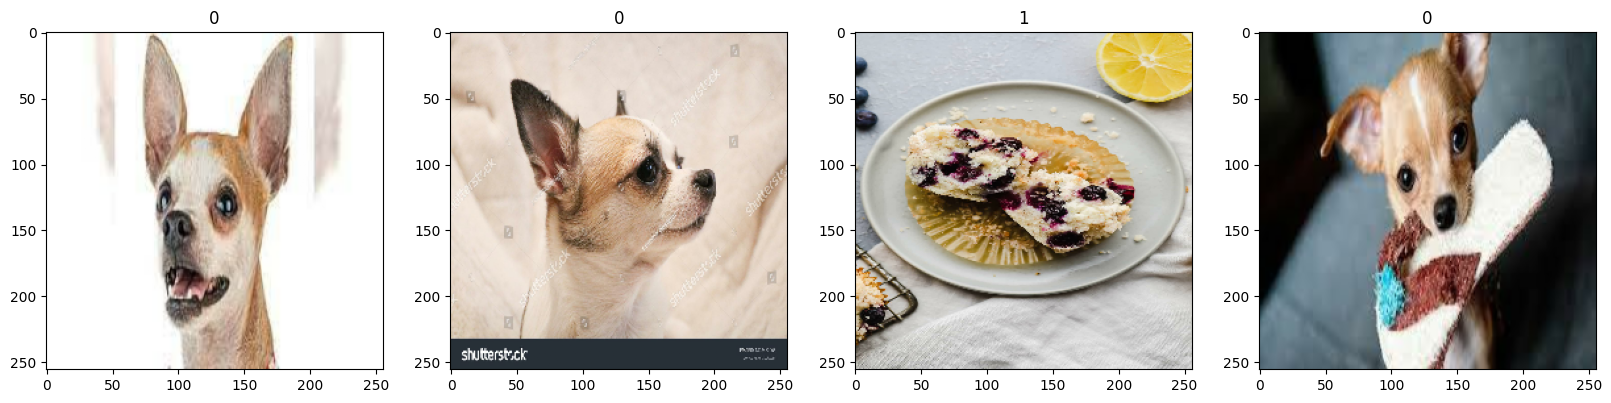

In [6]:
#making a numpy iterator
testData_iterator = testData.as_numpy_iterator()

#making batches
testBatch = testData_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(testBatch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(testBatch[1][idx])

In [ ]:
#@title Don't Use This Code
#class names set
class_name = ["chihuahua", "muffin"]

#define standard folder paths:
train_path = "/content/MufVSChu/train/"
test_path = "/content/MufVSChu/test/"

#define empty lists for both
train_images = []
train_labels = []

#loop through images in the train folder
for class_name in ["chihuahua", "muffin"]:
  class_path = os.path.join(train_path, class_name)
  # this is to join the path for each class folder

  #looping through all the images
  for filename in os.listdir(class_path):
    if filename.endswith(".jpg"):
      image_path = os.path.join(class_path, filename)
      #make the image path
      #add the images to the train_images array
      img = Image.open(image_path)
      train_images.append(img)
      #add the labels to the train_labels array
      label = 0 if class_name == "chihuahua" else 1
      train_labels.append(label)

#display the images
p = 0
plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  p = random.randint(0, len(train_images))
  plt.imshow(train_images[p])
  plt.xlabel(class_name[train_labels[p]])

plt.show()
print(len(train_images))
print(len(train_labels))


This is the original way of doing this. This, however, takes too long and does not load the images as sets of numpy arrays. By using this method, we will just get a very large array of images, which we would later have to convert to a NumPy array. This is a very bad idea as it will attempt to take all the images at once. Using the numpy iterator, however, will allow us to split the images into batches, convert, use, and then discard and move on.

### Preprocessing (continute)
We still need to preprocess the images to make sure everything is good.
We already did this before by scaling down from the range 0-255 down to 0-1. Now we need to split the data.

In [7]:
print("We have ", len(trainData), " batches for the training data.")
print("We have ", len(testData), " batches for the testing data.")

We have  48  batches for the training data.
We have  7  batches for the testing data.


Since we have these batches already partitioned, we are good to go. Additionally, however, I have chosen to add a validation partition as is good practice (will be from the train data set).

In [8]:
train_size = int(len(trainData)*0.7) + 1 #adding 1 bc without it, sets would only be 47
#train_size = 15
val_size = int(len(trainData)*0.3)
#val_size = 10
print("We should have ", train_size, " batches for the training data.")
print("We should have ", val_size, " batches for the validation data.")

We should have  34  batches for the training data.
We should have  14  batches for the validation data.


In [9]:
#now to actually partition it correctly
train = trainData.take(train_size)
val = trainData.skip(train_size).take(val_size)
test = testData
print("We actually have", len(train), "batches for our training data")
print("We actually have", len(val), "batches for our validation data")
print("We actually have", len(test), "batches for our testing data")

We actually have 34 batches for our training data
We actually have 14 batches for our validation data
We actually have 7 batches for our testing data


## Create the Convolutional Base
This is well explained by <a href = "https://www.youtube.com/watch?v=FK77zZxaBoI">this video</a>, but I'll do my best!   
Neural Networks are composed of layers. These layers can be thought of as "nodes" (as shown in the image below).
<img src="https://miro.medium.com/v2/resize:fit:1400/1*3fA77_mLNiJTSgZFhYnU0Q.png">   
<!--I dont think I have to close that img tag-->
There is an input layer, which is what we give the model. The model will then output something. The output layer may actually contain a few different categories, such as in this example, where there would be 2 outputs, one for Muffins and one for Chihuahuas.    
The real magic behind the systems is layers. These are what the input is passed through to decide what the input is. There can be multiple layers alongside multiple types of layers.
* Dense/Fully Connected Layer - used to connect the layers
* Convolutional Layer - typically used for images, consists of "filters"
* Pooling Layers - "pools" all the input to one output
* Recurrent Layers - used for time-series data
* Normalization Layers - scales input to a "normalized" form, better for "resilient" training
* Etc.      

Since this is about CNN, we will expand on convolutional layers. These filters assign a weight, which is really well explained in this post: <a href = "https://datascience.stackexchange.com/questions/18341/how-are-weights-represented-in-a-convolution-neural-network#:~:text=In%20convolutional%20layers%20the%20weights%20are%20represented%20as%20the%20multiplicative%20factor%20of%20the%20filters.">Convolutional Layers Weights</a>    
As seen below, we have 6 layers (the input layer is implied, see the last argument on the second line). We know what the pooling layers are, and we also know what the convolutional layers are as well. The arguments in both are as such:
```
Conv2D(filters, kernel_size, activation, input_shape)
```
* filters - the number of filters/kernels
* kernel_size - the size of the filter/kernel (the box that slides across in the "Convolutional Layers Weights" link above)
* activation - specific activation function (relu is common, <a href = "https://medium.com/@shrutijadon/survey-on-activation-functions-for-deep-learning-9689331ba092">to the google for more specifics</a>)
* input_shape - the shape of the input images; in this case they are all considered a 32*32 image, and the last 3 is for RGB; this last argument is always in the first layer but omitted at the other layers since there is only 1 entrance (like there is only 1 place to input before going through all the layers)

```
MaxPool2D(pool_size)
```
* pool_size - the size of the pool, adjusts accordingly (google for more information)


Using this information, let us continue.



In [10]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3))) #implied input layer
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Let's display the current archietecture of this model.

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

Let's break down our sequential model.   
* The output shapes given by the cond2D layer gives the dimensions of the batch size, the feature map size and the number of feature maps.
 * The first is (None, 254, 254, 32), meaning there are a varying number of batch sizes ("None"), the feature map size is 254*254 ("254, 254"), and there are 32 feature maps ("32")
* The total params are the total number of parameters collected by each layer. It is the simple addition of the column on the right.
* The trainable params are the number of the params that are updated during training.
* The non-trainable params are the number of the params that cannot be updated during training.


## Adding a Dense Layer On the Top
We'll be adding a few additional layers to finish up.   
The flatten layer will turn a 3D layer into a 1D layer.   
The dense layer will do what we described before, pulling everything together into the two classes.

In [12]:
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation ='sigmoid'))

## Compile and Summarize

In [13]:
#compile it
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      14,745,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,802,433 (56.47 MB)

 Trainable params: 14,802,433 (56.47 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [ ]:
hist = model.fit(train, epochs = 20, validation_data = val)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 161s 5s/step - accuracy: 0.5395 - loss: 1.3696 - val_accuracy: 0.8050 - val_loss: 0.4683
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - accuracy: 0.7916 - loss: 0.4380 - val_accuracy: 0.8753 - val_loss: 0.3357
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 160s 5s/step - accuracy: 0.8827 - loss: 0.2981 - val_accuracy: 0.8934 - val_loss: 0.3047
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 157s 5s/step - accuracy: 0.9218 - loss: 0.1985 - val_accuracy: 0.8821 - val_loss: 0.2554
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 158s 5s/step - accuracy: 0.9611 - loss: 0.1206 - val_accuracy: 0.9070 - val_loss: 0.2512
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 159s 5s/step - accuracy: 0.9750 - loss: 0.0821 - val_accuracy: 0.8844 - val_loss: 0.3026
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 160s 5s/step - accuracy: 0.9688 - loss: 0.0959 - val_accuracy: 0.8934 - val_loss: 0.3509
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 160s 5s/step - accuracy: 0.9773 - loss: 0.0608 - val_accuracy: 0.8730 - v

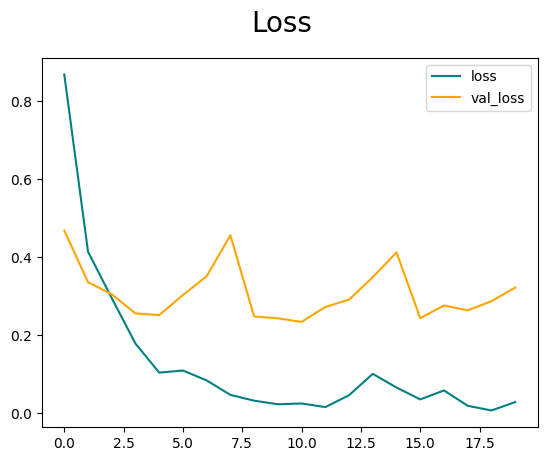

In [31]:
#plotting the loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

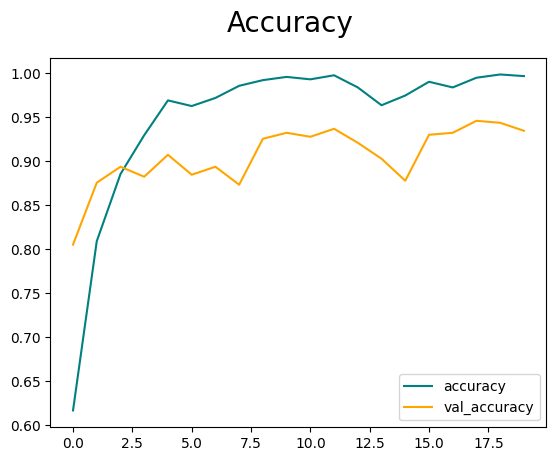

In [33]:
#plotting the accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()